# NEFT (National Electronic Funds Transfer) Analysis Pre and Post Demonetization

In [60]:
import pandas as pd
%matplotlib inline
import matplotlib.pylab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
df_index = ['2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12','2017-01','2017-02']
df_columns = ["Transaction(in mn)","Amount(in bn)"]
df_ = pd.DataFrame(index=df_index, columns=df_columns)

files=["neft_may.csv","neft_june.csv","neft_july.csv","neft_aug.csv","neft_sep.csv","neft_oct.csv","neft_nov.csv","neft_dec.csv","neft_jan.csv","neft_feb.csv"]

for idx,f_name in enumerate(files):
    bank_dat = pd.read_csv("C:/Users/mohinder/Data Analysis and M.Learning/neft/" + str(f_name))
    da = bank_dat.iloc[-1,3]
    df_.loc[df_index[idx],"Transaction(in mn)"]=float(bank_dat.iloc[-1,3])
    df_.loc[df_index[idx],"Amount(in bn)"]=float(bank_dat.iloc[-1,4])



In [61]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m').date()
df_.to_csv("C:/Users/mohinder/Data Analysis and M.Learning/neft/Result/bank_details.csv", sep=',')
df_ = pd.read_csv("C:/Users/mohinder/Data Analysis and M.Learning/neft/Result/bank_details.csv", parse_dates=True, index_col=0 ,date_parser=dateparse)
df_
df_.dtypes
df_

,Transaction(in mn),Amount(in bn)
2016-05-01,117.50,7732.54
2016-06-01,118.29,8815.31
2016-07-01,113.48,8145.39
2016-08-01,118.56,8764.14
2016-09-01,120.15,9880.17
2016-10-01,133.21,9504.50
2016-11-01,123.05,8807.88
2016-12-01,166.31,11537.63
2017-01-01,164.19,11355.08
2017-02-01,148.21,10877.91


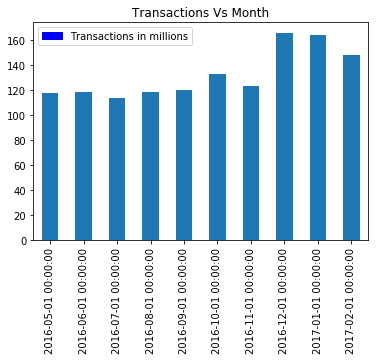

In [62]:
df_.iloc[:,0].plot(kind="bar")
plt.title("Transactions Vs Month")
red_patch = mpatches.Patch(color='blue', label='Transactions in millions')
plt.legend(handles=[red_patch])

Amount Transacted Vs Months

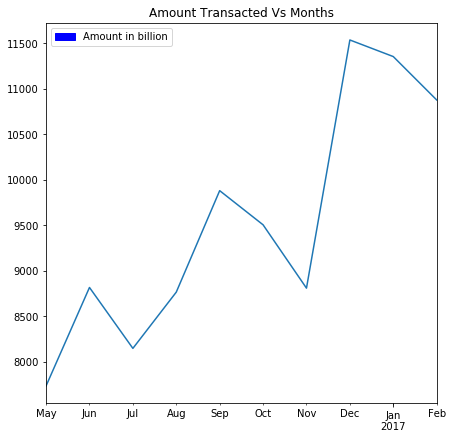

In [63]:
df_.iloc[:,1].plot(kind="line", figsize=(7,7))
plt.title("Amount Transacted Vs Months")
red_patch = mpatches.Patch(color='blue', label='Amount in billion')
plt.legend(handles=[red_patch])

In [64]:
df_.index

DatetimeIndex(['2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01'],
              dtype='datetime64[ns]', freq=None)

# Checking Stationarity

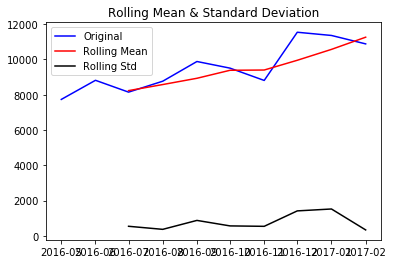

Results of Dickey-Fuller Test:
Test Statistic                -1.525867
p-value                        0.520678
#Lags Used                     0.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [65]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=3).mean()
    rolstd = pd.Series(timeseries).rolling(window=3).std()
    
     #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,0,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df_.iloc[:,1])
#pd.Series(df_.iloc[:,1]).rolling(window=9).mean()

So, here we can very well see that our test statistic comes out to be greater than critical values. Hence we infer that our timeseres model is not stationary yet.

# Eliminating Trend

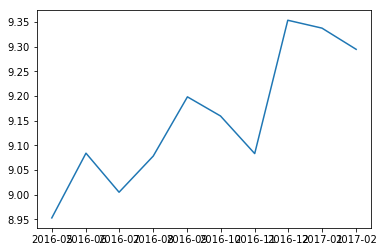

In [66]:
import numpy as np
df_log = np.log(df_.iloc[:,1])
plt.plot(df_log)

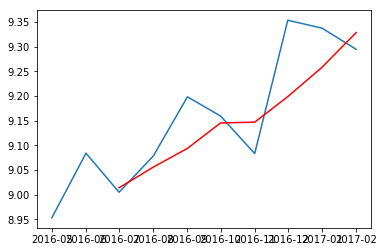

In [67]:
moving_avg = pd.Series(df_log).rolling(window=3).mean()
plt.plot(df_log)
plt.plot(moving_avg, color='red')

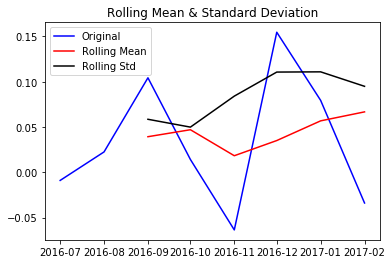

Results of Dickey-Fuller Test:
Test Statistic                -2.867272
p-value                        0.049288
#Lags Used                     0.000000
Number of Observations Used    7.000000
Critical Value (1%)           -4.938690
Critical Value (5%)           -3.477583
Critical Value (10%)          -2.843868
dtype: float64


In [68]:
ts_log_moving_avg_diff = df_log - moving_avg
# ts_log_moving_avg_diff.head()
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

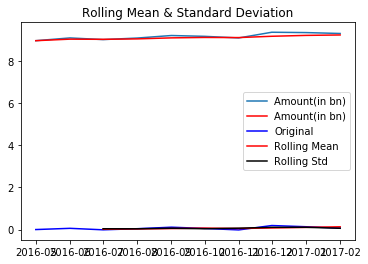

Results of Dickey-Fuller Test:
Test Statistic                -2.734337
p-value                        0.068283
#Lags Used                     0.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [69]:
expwighted_avg = pd.Series(df_log).ewm(halflife=3).mean()
plt.plot(df_log)
plt.plot(expwighted_avg, color='red')
ts_log_ewma_diff = df_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

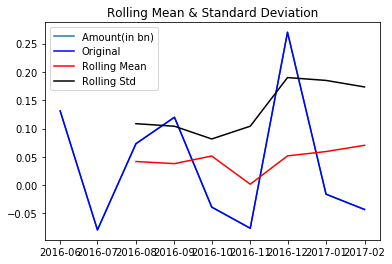

Results of Dickey-Fuller Test:
Test Statistic                -3.850060
p-value                        0.002435
#Lags Used                     0.000000
Number of Observations Used    8.000000
Critical Value (1%)           -4.665186
Critical Value (5%)           -3.367187
Critical Value (10%)          -2.802961
dtype: float64


In [70]:
ts_log_diff = df_log - df_log.shift()
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

Here we can see test statistic is lesser than 5% critical value . Hence TS is stationary with 95% confidence.

# Forecasting Time Series

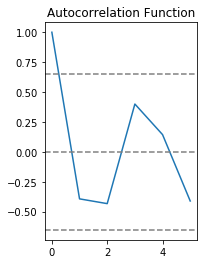

In [71]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=5)
lag_pacf = pacf(ts_log_diff, nlags=5, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


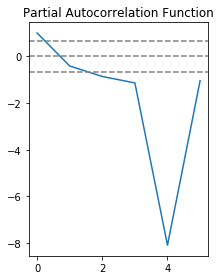

In [72]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

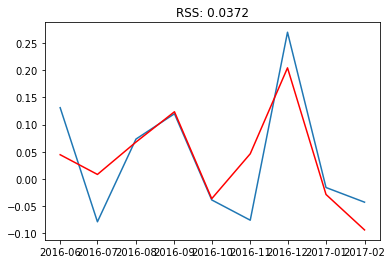

In [73]:
from statsmodels.tsa.arima_model import ARIMA
# p=1,q=1
model = ARIMA(df_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [74]:
# model = ARIMA(df_log, order=(0, 1, 1))  
# results_MA = model.fit(disp=-1)  
# plt.plot(ts_log_diff)
# plt.plot(results_MA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

In [75]:
# print(df_log)
# model = ARIMA(df_log, order=(1, 1, 1))  
# results_ARIMA = model.fit(disp=-1)  
# plt.plot(ts_log_diff)
# plt.plot(results_ARIMA.fittedvalues, color='red')
# plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [76]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

2016-06-01    0.044454
2016-07-01    0.008160
2016-08-01    0.067708
2016-09-01    0.123565
2016-10-01   -0.036534
2016-11-01    0.046176
2016-12-01    0.204408
2017-01-01   -0.028744
2017-02-01   -0.094009
dtype: float64
2016-06-01    0.044454
2016-07-01    0.052614
2016-08-01    0.120322
2016-09-01    0.243887
2016-10-01    0.207353
dtype: float64


2016-05-01     7732.540000
2016-06-01     8084.038866
2016-07-01     8150.272729
2016-08-01     8721.222268
2016-09-01     9868.269895
2016-10-01     9514.244309
2016-11-01     9963.872633
2016-12-01    12223.669810
2017-01-01    11877.319202
2017-02-01    10811.623644
dtype: float64


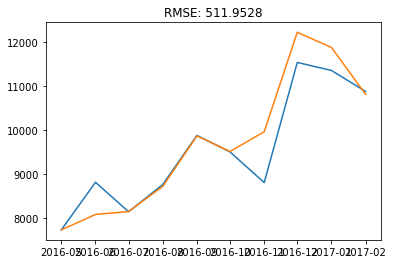

In [77]:
predictions_ARIMA_log = pd.Series(df_log.ix[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df_.iloc[:,1])
plt.plot(predictions_ARIMA)
print(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_.iloc[:,1])**2)/len(df_)))

In [78]:
df_.iloc[:,1]

2016-05-01     7732.54
2016-06-01     8815.31
2016-07-01     8145.39
2016-08-01     8764.14
2016-09-01     9880.17
2016-10-01     9504.50
2016-11-01     8807.88
2016-12-01    11537.63
2017-01-01    11355.08
2017-02-01    10877.91
Name: Amount(in bn), dtype: float64

# Predicted Value for Feb.

In [59]:
results_AR.predict(start='2017-02',end='2017-02')


C:\Users\mohinder\Anaconda3\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


2017-02-01   -0.145126
Freq: MS, dtype: float64